In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
os.getcwd()

'/Users/lsafari/drone_steering/models/playground'

In [5]:
os.chdir('../..')

In [6]:
from app_local.module import DataEnsembler, GestureTransformer

In [7]:
is_frame_based = True

In [8]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = is_frame_based)

In [9]:
de.load_data()
de.assemble_data(tolerance_range = 600, max_error = 500)
de.display_information()

i: 0 	shape X: (551, 17, 16) 	shape y: (551,) 	count: 58
i: 1 	shape X: (542, 17, 16) 	shape y: (542,) 	count: 49
i: 2 	shape X: (591, 17, 16) 	shape y: (591,) 	count: 115
i: 3 	shape X: (617, 17, 16) 	shape y: (617,) 	count: 57
i: 4 	shape X: (467, 17, 16) 	shape y: (467,) 	count: 86
i: 5 	shape X: (441, 17, 16) 	shape y: (441,) 	count: 83
i: 6 	shape X: (437, 17, 16) 	shape y: (437,) 	count: 63
i: 7 	shape X: (550, 17, 16) 	shape y: (550,) 	count: 55
i: 8 	shape X: (924, 17, 16) 	shape y: (924,) 	count: 118
i: 9 	shape X: (546, 17, 16) 	shape y: (546,) 	count: 47
i: 10 	shape X: (477, 17, 16) 	shape y: (477,) 	count: 74
i: 11 	shape X: (622, 17, 16) 	shape y: (622,) 	count: 150
i: 12 	shape X: (552, 17, 16) 	shape y: (552,) 	count: 71
i: 13 	shape X: (506, 17, 16) 	shape y: (506,) 	count: 57
i: 14 	shape X: (536, 17, 16) 	shape y: (536,) 	count: 74
i: 15 	shape X: (515, 17, 16) 	shape y: (515,) 	count: 64
i: 16 	shape X: (548, 17, 16) 	shape y: (548,) 	count: 67
i: 17 	shape X: (550,

In [34]:
de.LabelGenerators[0].feature_names

Index(['leftElbow_x', 'leftElbow_y', 'leftHip_x', 'leftHip_y',
       'leftShoulder_x', 'leftShoulder_y', 'leftWrist_x', 'leftWrist_y',
       'rightElbow_x', 'rightElbow_y', 'rightHip_x', 'rightHip_y',
       'rightShoulder_x', 'rightShoulder_y', 'rightWrist_x', 'rightWrist_y'],
      dtype='object')

In [35]:
feature_names = list(de.LabelGenerators[0].feature_names)
feat_dict = {feature:feature_names.index(feature) for feature in feature_names}
feat_dict

{'leftElbow_x': 0,
 'leftElbow_y': 1,
 'leftHip_x': 2,
 'leftHip_y': 3,
 'leftShoulder_x': 4,
 'leftShoulder_y': 5,
 'leftWrist_x': 6,
 'leftWrist_y': 7,
 'rightElbow_x': 8,
 'rightElbow_y': 9,
 'rightHip_x': 10,
 'rightHip_y': 11,
 'rightShoulder_x': 12,
 'rightShoulder_y': 13,
 'rightWrist_x': 14,
 'rightWrist_y': 15}

In [11]:
def plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist', is_frame_based = True):

    global movements
    
    kx = body_part + '_x'
    ky = body_part + '_y'

    lgen = de.LabelGenerators[file_id]
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]

    d = lgen.labeled_data
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]    
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                title_suffix = ''
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))
                    title_suffix = ' | ' + movements[int(y[index])]

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")
                
                if is_frame_based:
                    plt.title(str(index) + title_suffix)
                else:
                    plt.title(str(index) + "/" + str(round(lgen.sequence_end_time[index]/1000,2)) + " l=" + str(int(y[index])))
                

        plt.show()
        plt.close()    

In [39]:
lgen=de.LabelGenerators[0]

In [40]:
y = lgen.y
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4.,
       4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4.,
       4., 4., 0., 0., 0.

In [42]:
d = lgen.labeled_data
d[:5]

,leftElbow_x,leftElbow_y,leftHip_x,leftHip_y,leftShoulder_x,leftShoulder_y,leftWrist_x,leftWrist_y,rightElbow_x,rightElbow_y,rightHip_x,rightHip_y,rightShoulder_x,rightShoulder_y,rightWrist_x,rightWrist_y
0,339.645417,203.705534,330.407067,258.037608,333.380549,148.602443,342.567651,249.470969,275.543020,204.651765,283.540808,260.224541,264.726575,154.627280,300.359013,237.072710
1,337.786904,205.850688,327.399147,258.864759,330.848589,148.049523,340.435470,248.522660,277.494674,205.260721,281.169772,261.682108,261.755806,153.668497,296.698546,237.662307
2,338.685882,206.986778,324.564567,258.101021,328.558816,148.634461,338.665330,248.671895,277.059992,205.260906,279.815672,261.891973,261.654127,149.963742,296.281542,238.713595
3,333.988439,203.014023,325.005074,255.324383,324.594274,149.952849,332.402070,246.166552,264.881713,211.749755,278.496858,252.943875,257.004254,147.569787,291.442563,242.062138
4,331.709428,201.457220,321.863894,258.354153,323.063889,149.678942,331.523280,249.304504,266.559882,206.189193,275.284629,253.912468,256.708338,152.518573,281.260651,239.180397


In [45]:
d.shape

(567, 16)

In [24]:
def two_plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist', \
                    body_part_two='rightWrist', is_frame_based = True):

    global movements
    
    kx = body_part + '_x'
    ky = body_part + '_y'
    kx2 = body_part_two + '_x'
    ky2 = body_part_two + '_y'

    lgen = de.LabelGenerators[file_id]
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]

    d = lgen.labeled_data
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]    
    Dx2 = D[:,feat_dict[kx2]]
    Dy2 = D[:,feat_dict[ky2]]    
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                title_suffix = ''
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))
                    title_suffix = ' | ' + movements[int(y[index])]

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")
                plt.plot(Dx2[l1:u1],Dy2[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")
                plt.plot(Dx2[l2:u2+1],Dy2[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                plt.plot(Dx2[l3:u3],Dy2[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")
                plt.plot(Dx2[u1-1],Dy2[u1-1],color = "xkcd:baby blue",marker = "o")
                
                if is_frame_based:
                    plt.title(str(index) + title_suffix)
                else:
                    plt.title(str(index) + "/" + str(round(lgen.sequence_end_time[index]/1000,2)) + " l=" + str(int(y[index])))
                

        plt.show()
        plt.close() 

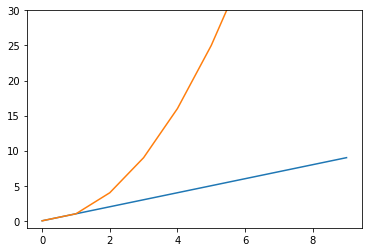

In [32]:
plt.plot([x for x in range(10)], [x for x in range(10)])
plt.plot([x for x in range(10)], [x**2 for x in range(10)])
plt.ylim(-1,30)
plt.show()

Available body parts:
```
leftElbow
leftHip
leftShoulder
leftWrist
rightElbow
rightHip
rightShoulder
rightWrist
```

In [12]:
de.combined_data_files_df

,filename_features,filename_labels
0,features_left_c_02_120.csv,labels_left_c_02.csv
1,features_left_l_01_120.csv,labels_left_l_01.csv
2,features_move_p_01_120.csv,labels_move_p_01.csv
3,features_move_c_01_120.csv,labels_move_c_01.csv
4,features_land_l_03_120.csv,labels_land_l_03.csv
5,features_land_c_01_120.csv,labels_land_c_01.csv
6,features_land_l_02_120.csv,labels_land_l_02.csv
7,features_left_c_03_120.csv,labels_left_c_03.csv
8,features_right_c_02_120.csv,labels_right_c_02.csv
9,features_right_l_01_120.csv,labels_right_l_01.csv


**Legend:**<br>
<span style="color:blue">gesture</span><br>
<span style="color:red">frames *after* gesture</span><br>
<span style="color:green">frames *before* gesture</span>

In [13]:
movements = {0: 'not detected',
             1: 'takeoff',
             2: 'move',
             3: 'flip',
             4: 'left',
             5: 'right',
             6: 'land'}

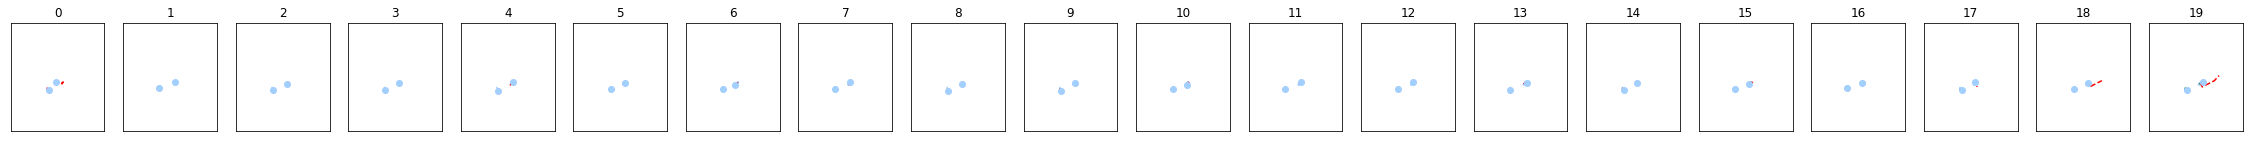

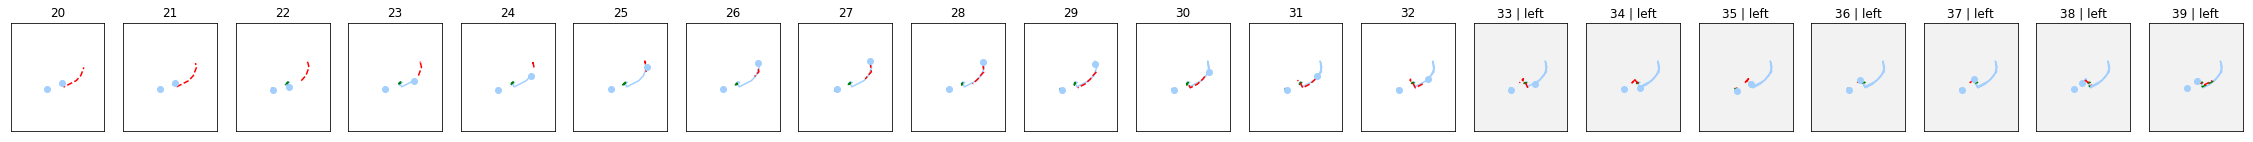

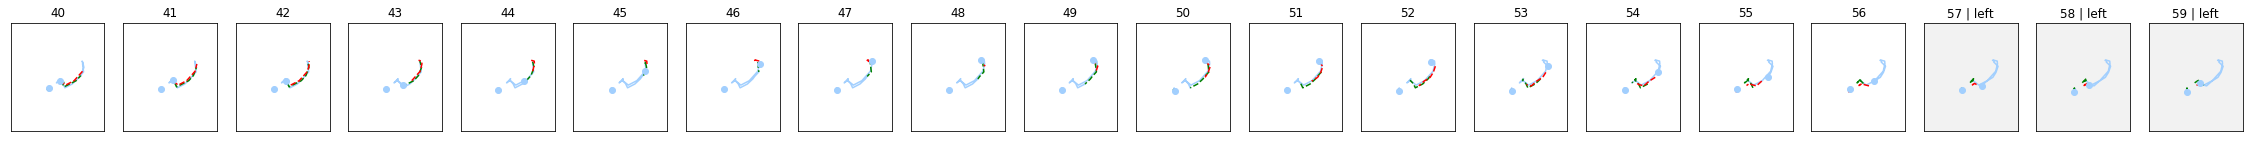

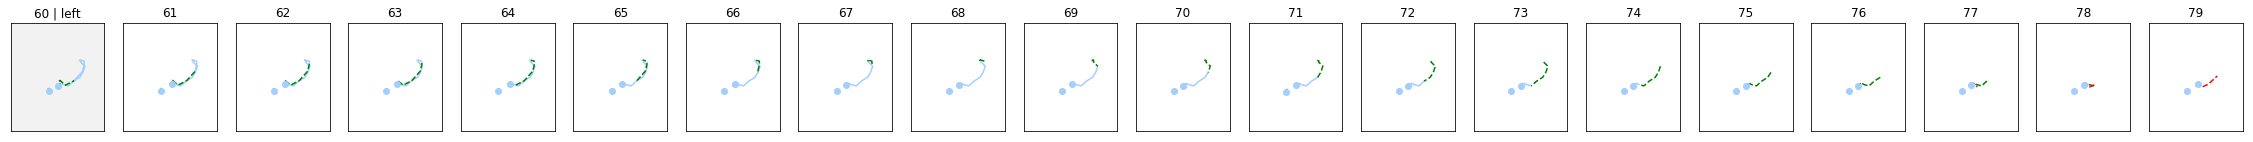

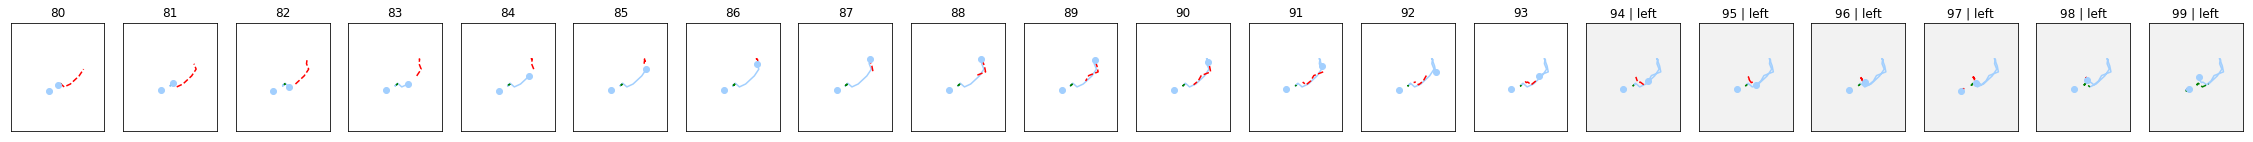

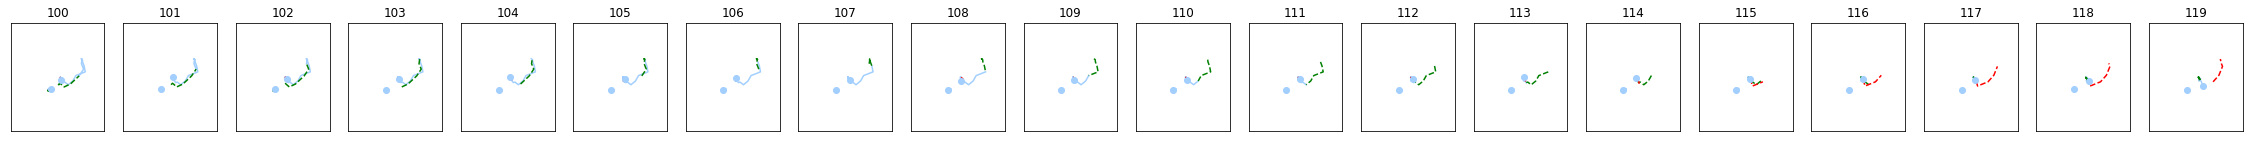

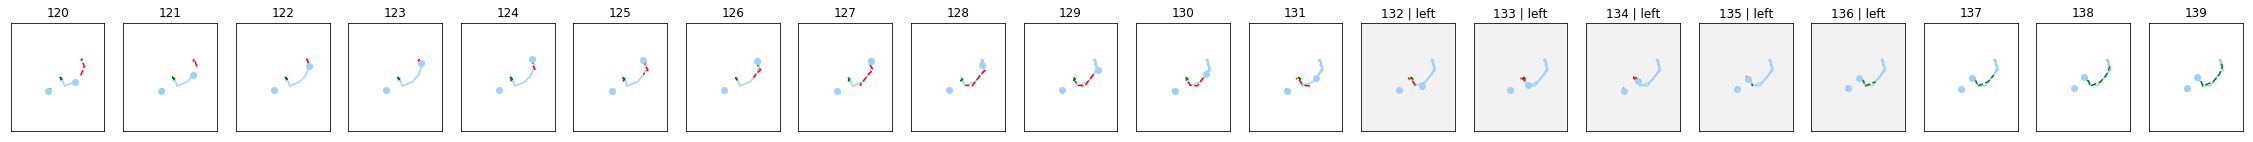

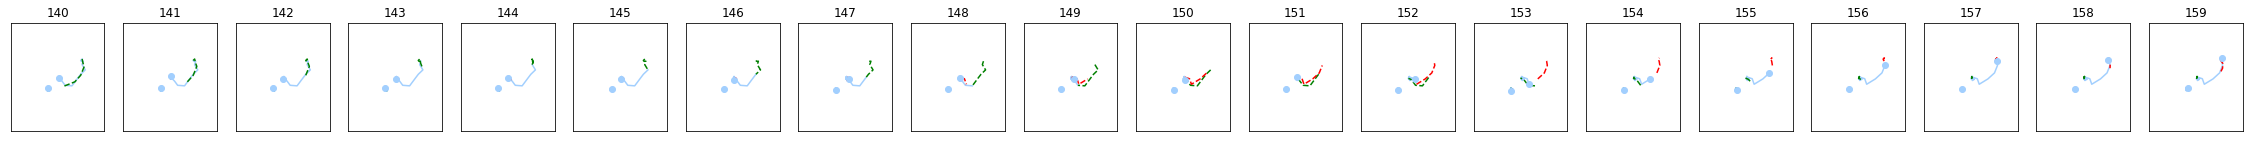

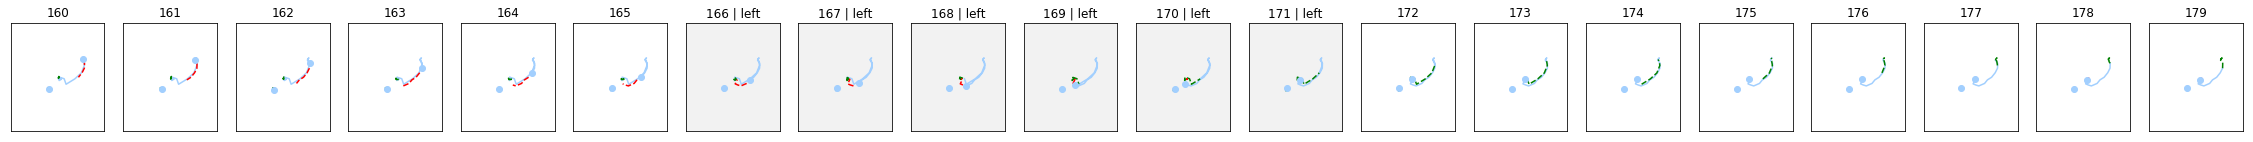

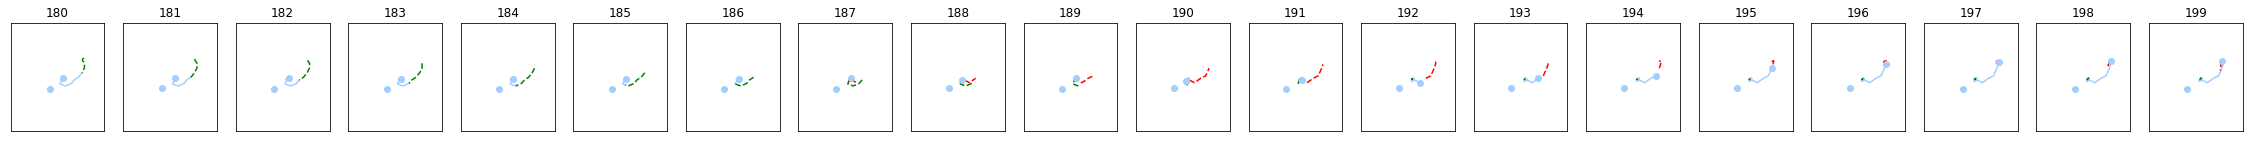

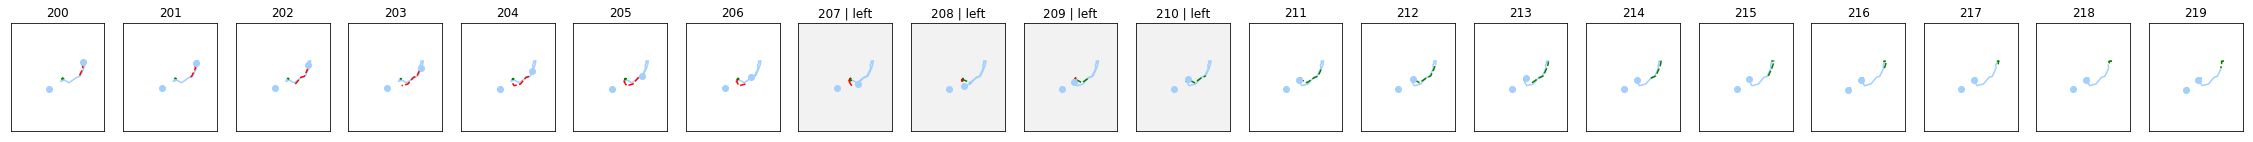

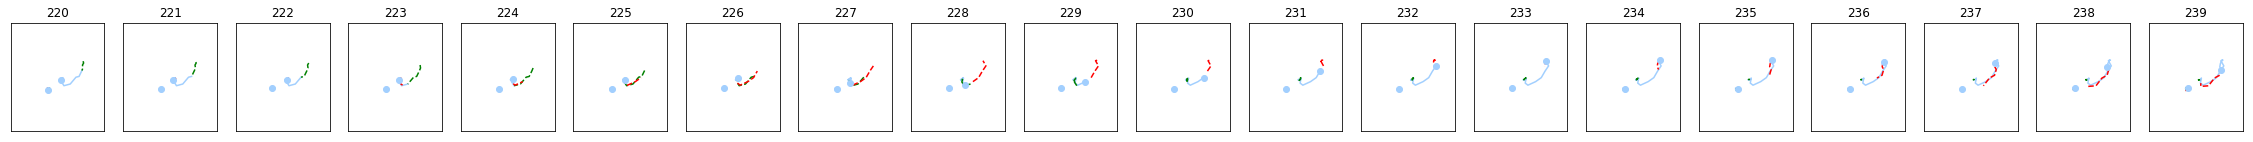

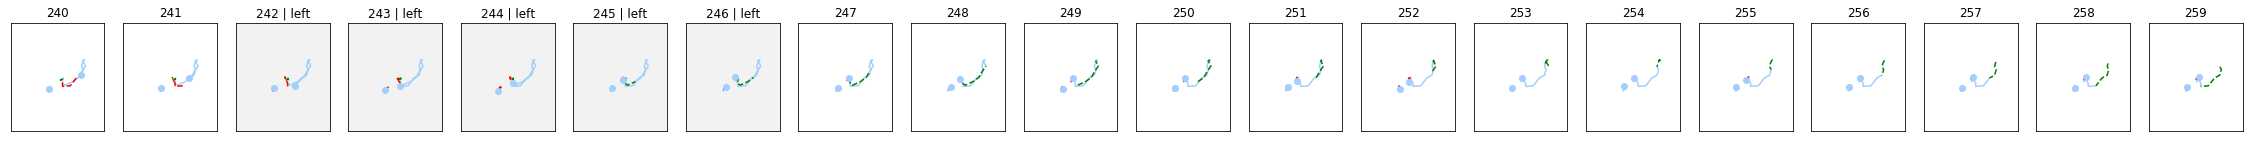

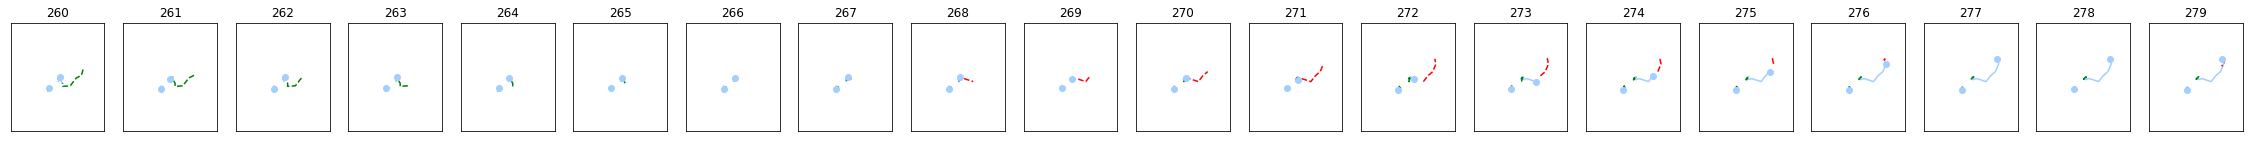

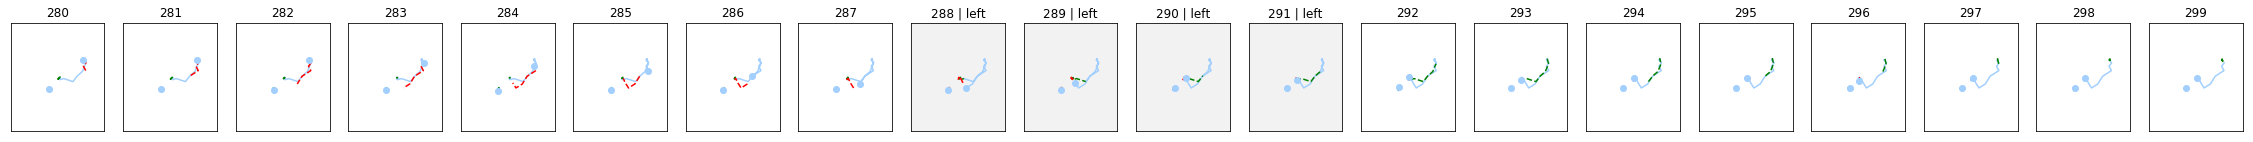

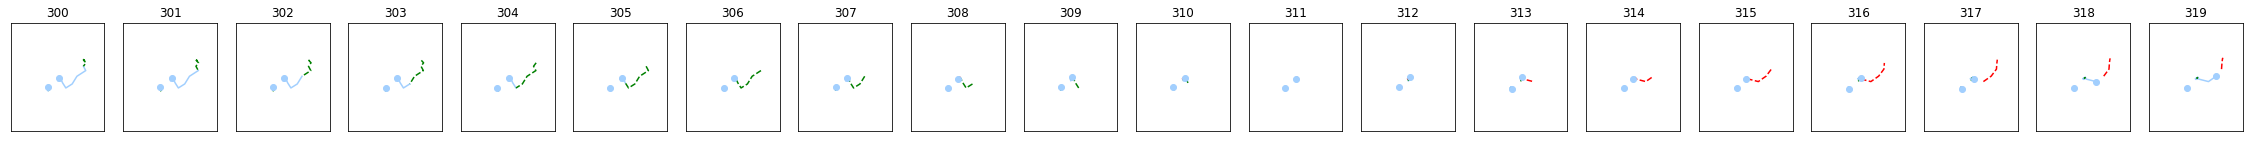

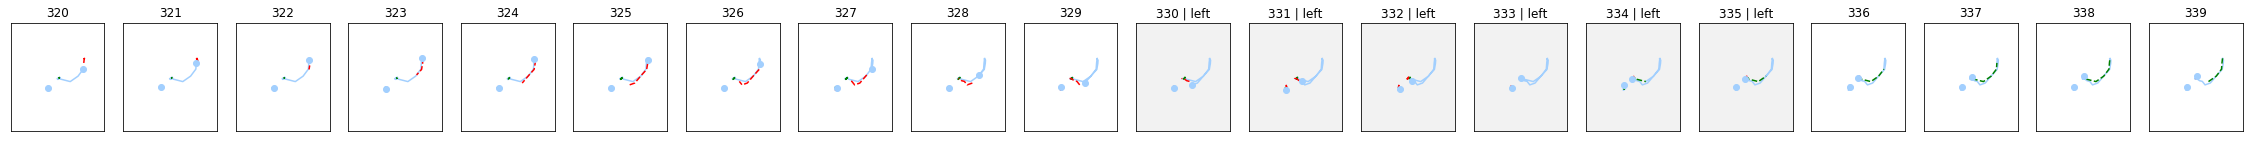

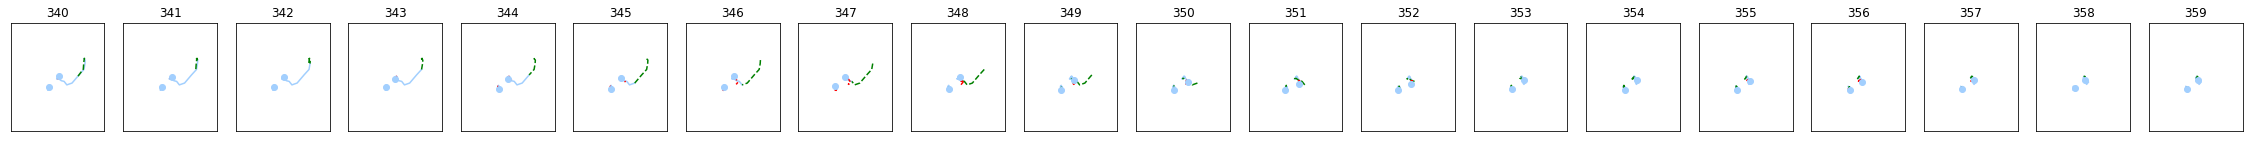

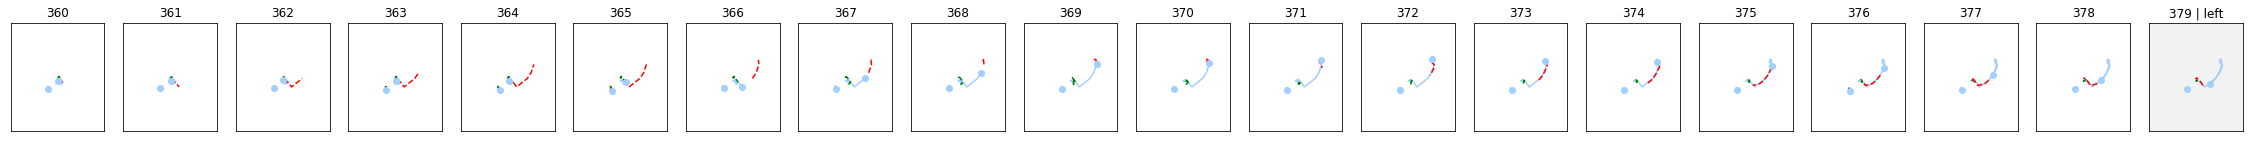

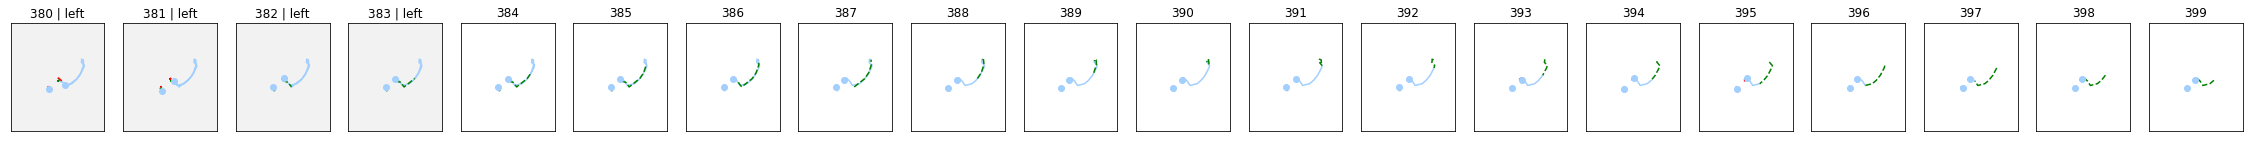

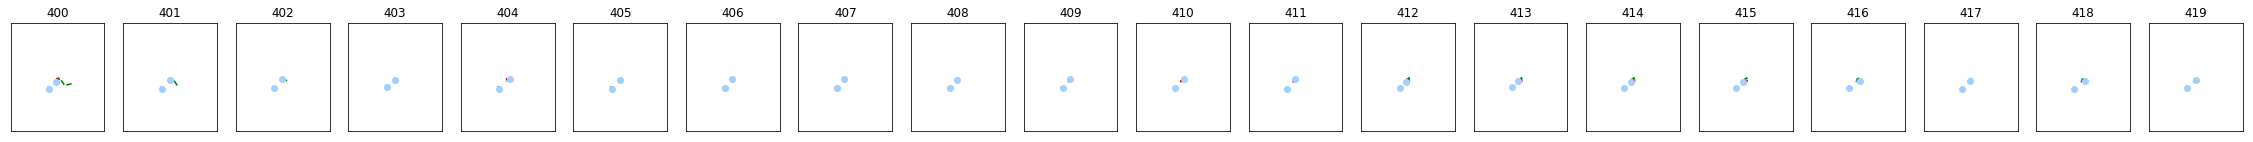

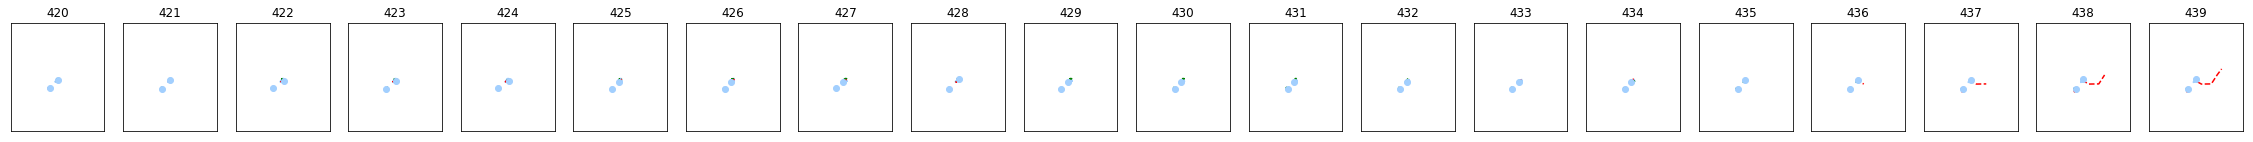

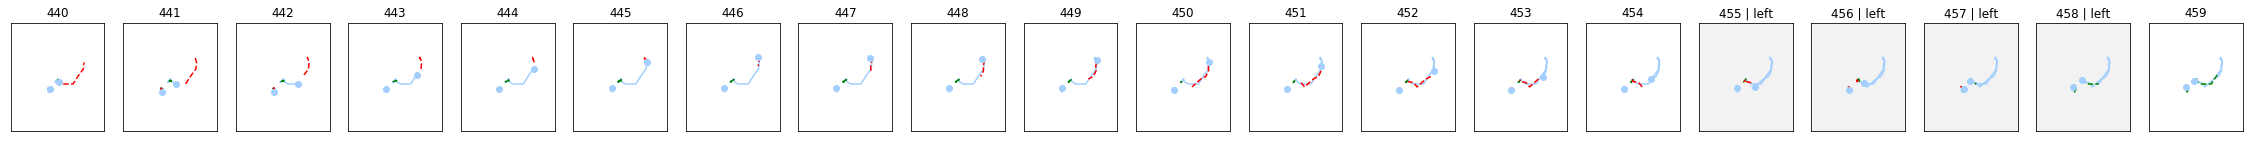

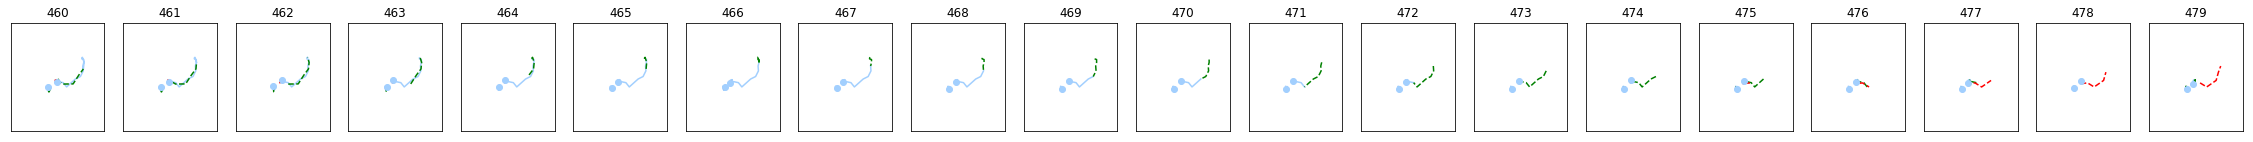

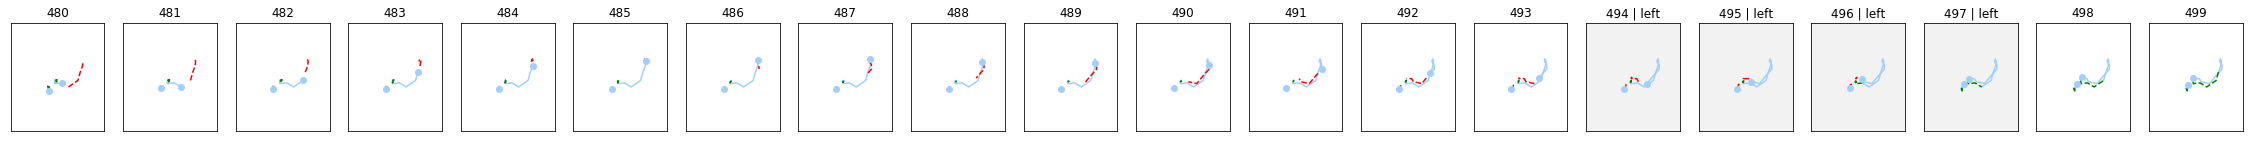

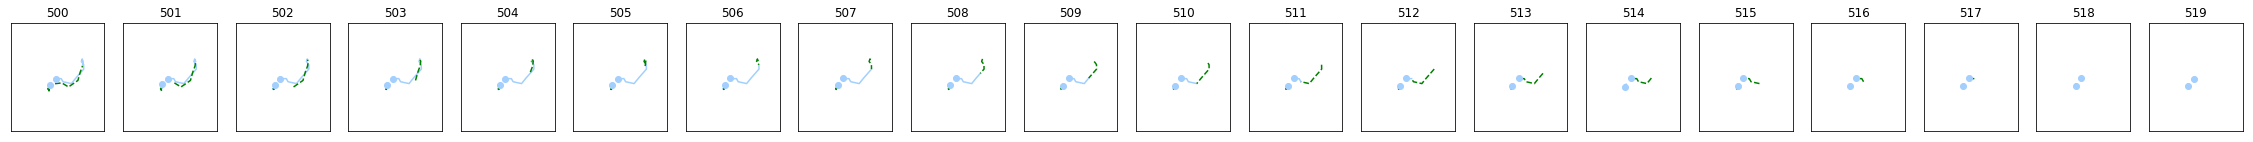

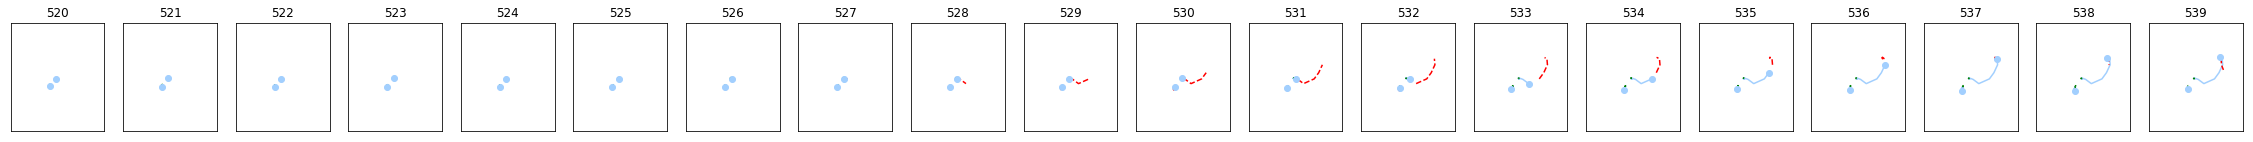

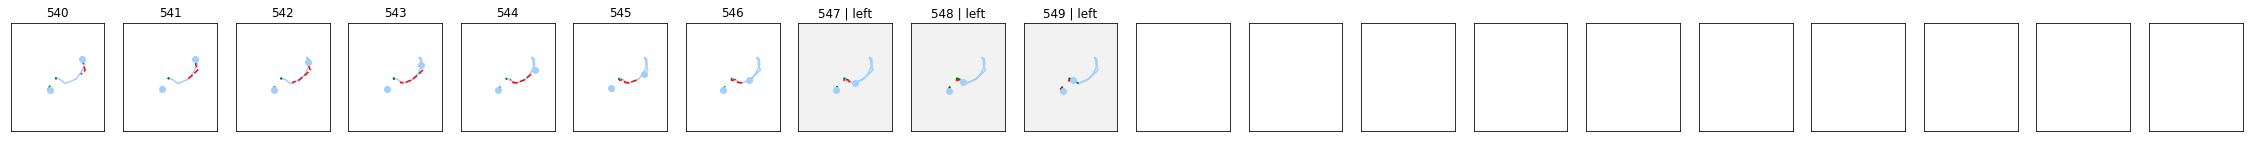

In [26]:
file_id = 17
#plot_charts(de, file_id=file_id, tail=5, head=5, plots_per_row=20, body_part='rightWrist', is_frame_based = is_frame_based)
two_plot_charts(de, file_id=file_id, tail=5, head=5, plots_per_row=20, body_part='leftWrist',body_part_two='rightWrist', is_frame_based = is_frame_based)

Display the movement endpoints (in milliseconds) of all non-zero labeled gestures:

In [15]:
de.LabelGenerators[file_id].label_df.join(de.LabelGenerators[file_id].label_info)

AttributeError: 'LabelGeneratorFramebased' object has no attribute 'label_df'

Display the indices of movement ends of all non-zero labeled gestures:

In [ ]:
lgen = de.LabelGenerators[file_id]
y = lgen.y

gt = GestureTransformer(byrow=True, feature_names=feature_names)
X = gt.transform(lgen.X)

gt = GestureTransformer(feature_names)
P = gt.transform(de.X)

key = 'leftWrist'
kx = key + '_x'
ky = key + '_y'

# get the label which is used in the current file
lab = y[y>0][0]

this_set = True
if not this_set: #use all the data
    movementData = P[np.isclose(de.y,lab),:,:]
else:
    movementData = X[np.isclose(y,lab),:,:]

print(movementData.shape)
movementData = movementData[:,:,[feat_dict[kx],feat_dict[ky]]]
avgMovement = movementData.mean(axis = 0)
avgMovement